### В данном ноутбуке содержатся реализации следующих гипотез:

Одна нормальная выборка, дисперсия известна, односторонняя или двусторонняя альтернатива:

1) Простая vs. простая гипотезы.

2) Простая vs. сложная гипотезы.

* модификация гипотезы $H_0$

* метод Линдли

* априор с атомом

3) сложная vs. сложная гипотезы.

Две нормальные независимые выборки, дисперсия известна, гипотеза $H_0: \theta_x = \theta_x ~vs~ H_1: \theta_x \neq \theta_x$.

In [2]:
import numpy as np
import scipy.stats as sps

from collections import namedtuple
from tqdm import tqdm_notebook

from matplotlib import pyplot as plt

# Одна нормальная выборка, дисперсия известна.

### I. Гипотеза: простая vs. простая.

Дано: 

1) Выборка $X_1, ..., X_n \sim \mathcal{N}(\theta, \sigma^2)$, $\sigma^2$ известна.

2) Априорное распределение $q_{pr} \sim \mathcal{N}(t_0, \sigma_{pr}^2)$.

---------

Тестируется гипотеза: $H_0: \theta = t_0 ~vs~ H_1: \theta = t_1$.

Тогда апостериорная вероятность нулевой гипотезы $p_0 = P(\theta = t_0 ~|~ X) \propto P(\theta = t_0)p_{t_0}(X) = \pi_0p_{t_0}(X)$

Апостериорную вероятность можно вычислить через байесовский фактор:

$\Large p_0 = (1 + \frac{\pi_1}{\pi_0}B^{-1})^{-1}$, где $\Large B = \frac{p_{t_0}(X)}{p_{t_1}(X)} = \frac{L_X(t_0)}{L_X(t_1)}$ - отношение правдоподобия.

In [61]:
from collections import namedtuple

def normal_test_known_var_ss(x, t_pr, sigma, t_1, pi_0):
    """ 
    Parameters
    ----------
    x: numpy array
        Array of samples, should be one-dimensional.  
    t_pr : float
        prior loc parameter
    sigma : positive float
        prior std parameter
    t_1 : float
        alternative mean parameter
    pi_0 : float, from [0, 1]
        prior probability of {theta == t_0}

    Returns
    -------
    t_post : float
    sigma_post : float
    B : float
    """
    
    assert len(x.shape) == 1
    
    n = x.shape[0]
    
    # Априорное распределение
    distr_pr = sps.norm(loc=t_pr, scale=sigma)
    
    # Параметры апостериорного распределения 
    t_post = (x.sum() + t_pr) / (n + 1)
    sigma_post = sigma / ((n + 1) ** 0.5)
    
    # Апостериорное распределение
    distr_post = sps.norm(loc=t_post, scale=sigma_post)
    
    # Вычисляем байесовский фактор
    B = np.exp(sps.norm(loc=t_pr, scale=sigma).logpdf(x).sum() - sps.norm(loc=t_1, scale=sigma).logpdf(x).sum())
    
    # Вычисляем апостериорную вероятность нулевой гипотезы
    p_0 = 1 / (1 + (1 - pi_0) / pi_0 / B)
    p_1 = 1 - p_0
    
    return namedtuple('test_result', ('t_post', 'sigma_post', 'B', 'p_0'))(t_post, sigma_post, B, p_0)

---

##### Тесты

---

$X_1, ..., X_{100} \sim \mathcal{N}(0, 1)$

$H_0: \theta = 0  ~vs~ H_1: \theta = 0.1$

Чем больше априорная вероятность нулевой гипотезы, тем больше апостериорная.

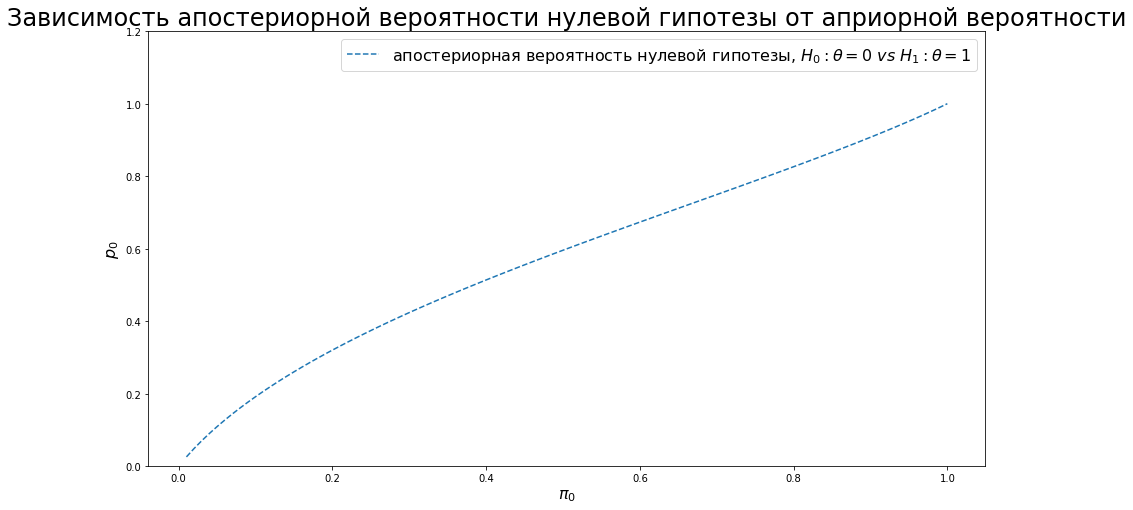

In [67]:
x = sps.norm(0, 1).rvs((1000, 100))

pi = np.linspace(0.01, 1, 100)

p = []

for i in tqdm_notebook(range(len(pi))):
    p.append(np.mean([normal_test_known_var_ss(x[j], 0, 1, 0.1, pi_0=pi[i]).p_0 for j in range(1000)]))

plt.figure(figsize=(15, 8))
plt.plot(pi, p, '--', label='апостериорная вероятность нулевой гипотезы, $H_0: \\theta = 0 ~vs~ H_1: \\theta = 0.1$')
plt.title('Зависимость апостериорной вероятности нулевой гипотезы от априорной вероятности', fontsize=24)
plt.legend(fontsize=16)
plt.xlabel('$\\pi_0$', fontsize=16)
plt.ylabel('$p_0$', fontsize=16)
plt.ylim((0, 1.2))
plt.show()

$X_1, ..., X_{100} \sim \mathcal{N}(0, 1)$

$H_0: \theta = t_0 ~vs~ H_1: \theta = 0$

Чем больше $t_0$, тем меньше байесовский фактор.

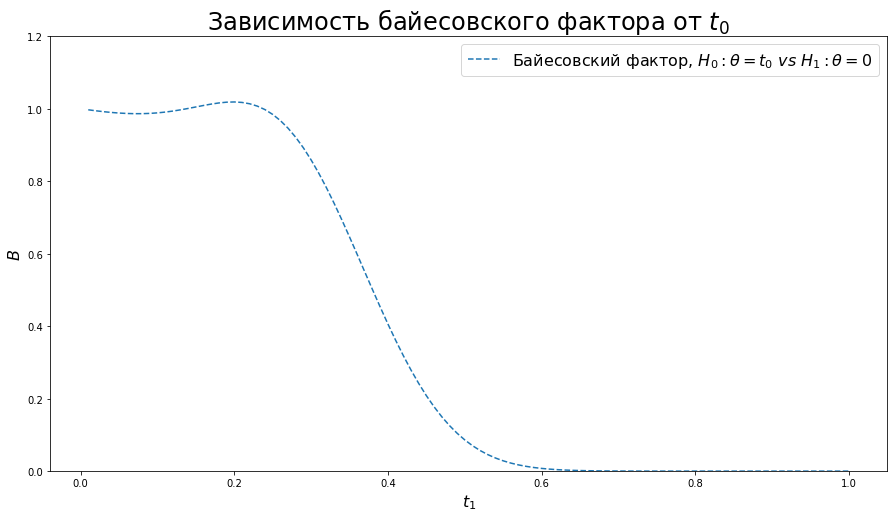

In [69]:
x = sps.norm(0, 1).rvs((1000, 100))

t = np.linspace(0.01, 1, 100)

B = []

for i in tqdm_notebook(range(len(t))):
    B.append(np.mean([normal_test_known_var_ss(x[j], t[i], 1, 0, pi_0=0.5).B for j in range(1000)]))

plt.figure(figsize=(15, 8))
plt.plot(pi, B, '--', label='Байесовский фактор, $H_0: \\theta = t_0 ~vs~ H_1: \\theta = 0$')
plt.title('Зависимость байесовского фактора от $t_0$', fontsize=24)
plt.legend(fontsize=16)
plt.xlabel('$t_1$', fontsize=16)
plt.ylabel('$B$', fontsize=16)
plt.ylim((0, 1.2))
plt.show()

### II. Гипотеза: простая vs. сложная, модификация $H_0$.

Дано: 

1) Выборка $X_1, ..., X_n \sim \mathcal{N}(\theta, \sigma^2)$, $\sigma^2$ известна.

2) Априорное распределение $q_{pr} \sim \mathcal{N}(t_0, \sigma_{pr}^2)$.

---------

Тестируется гипотеза: $H_0: \theta = t_0 ~vs~ H_1: \theta \neq t_0$.

Наблюдение: значения в окрестности $t_0$ с практической точки зрения не отличаются от $t_0$.

Модифицируем гипотезу: $H_0^{'}: \theta \in \Theta_0 = (t_0 - \epsilon, t_0 + \epsilon) ~vs~ H_1^{'}: \theta \notin \Theta_0$.

Апостериорное распределение: $\theta | X \sim \mathcal{N}(t_{post}, \sigma_{post}^2)$, где:

* $\Large t_{post} = \frac{\frac{\sum\limits_{i=1}^n X_i}{\sigma^2} + \frac{t_0}{\sigma_{pr}^2}}{\frac{n}{\sigma^2} + \frac{1}{\sigma_{pr}^2}} = ~[$В нашем случае $\sigma = \sigma_{pr}$ $\Large ] ~= \frac{\sum\limits_{i=1}^n X_i + t_0}{n + 1}$

* $\Large \sigma_{post}^2 = \frac{1}{\frac{n}{\sigma^2} + \frac{1}{\sigma_{pr}^2}} = ~[$ В нашем случае $\sigma = \sigma_{pr} $ $\Large ] ~= \frac{\sigma^2}{n + 1}$

Байесовский фактор вычисляется как $\Large B = \frac{p_0\pi_1}{p_1\pi_0}$, где:

* $\pi_0, \pi_1 ~-$ априорные вероятности соответствующих гипотез.

* $p_0, p_1 ~-$ апостериорные вероятности соответствующих гипотез.

In [91]:
from collections import namedtuple

def normal_test_known_var_sh_modification(x, t_pr, sigma, eps=0.05, alpha=0.95, alternative='two-sided'):
    """ 
    Parameters
    ----------
    x: numpy array
        Array of samples, should be one-dimensional.  
    t_pr : float
        prior loc parameter
    sigma : positive float
        prior std  parameter
    eps : positive float 
        width of null hypothesis
    alternative : 'less', 'two-sided', или 'greater'
        тип тестируемой гипотезы

    Returns
    -------
    t_post : float
    sigma_post : float
    B : float
    """
    
    assert len(x.shape) == 1
    
    n = x.shape[0]
    
    # Априорное распределение
    distr_pr = sps.norm(loc=t_pr, scale=sigma)
    
    # Параметры апостериорного распределения 
    t_post = (x.sum() + t_pr) / (n + 1)
    sigma_post = sigma / ((n + 1) ** 0.5)
    
    # Апостериорное распределение
    distr_post = sps.norm(loc=t_post, scale=sigma_post)
    
    # Априорные и апостериорные вероятности гипотез
    pi_0 = distr_pr.cdf(t_pr + eps) - distr_pr.cdf(t_pr - eps)
    p_0 = distr_post.cdf(t_pr + eps) - distr_post.cdf(t_pr - eps)
    
    # Вычисляем вероятности в зависимости от альтернативы
    # А также границы довкерительного интервала
    if alternative == 'two-sided':
        pi_1 = 1 - pi_0
        p_1 = 1 - p_0
        theta_left, theta_right = distr_post.interval(alpha)
    elif alternative == 'less':
        pi_1 = distr_pr.cdf(t_pr - eps)
        p_1 = distr_post.cdf(t_pr - eps)
        theta_left = distr_post.ppf(distr_post.cdf(t_post) * (1 - alpha))
        theta_right = t_post
    elif alternative == 'greater':
        pi_1 = distr_pr.sf(t_pr + eps)
        p_1 = distr_post.sf(t_pr + eps)
        theta_left = t_post
        theta_right = distr_post.ppf(1 - distr_post.sf(t_post) * (1 - alpha))  
    else:
        raise Exception("Unknown alternative")
    
    # Нормируем вероятности
    pi_sum = pi_0 + pi_1
    p_sum = p_0 + p_1
    
    pi_0 /= pi_sum
    pi_1 /= pi_sum
    p_0 /= p_sum
    p_1 /= p_sum

    # Вычисляем байесовский фактор
    B = (p_0 * pi_1) / (p_1 * pi_0)
    
    return namedtuple('test_result', ('t_post', 'sigma_post', 'B', 'HDR')) \
            (t_post, sigma_post, B, (theta_left, theta_right))

---

##### Тесты

---

$X_1, ..., X_{100} \sim \mathcal{N}(0, 1)$

$H_0: t_0 = 0$

Чем больше $\epsilon$, тем больше байесовский фактор при справедливости нулевой гипотезы.

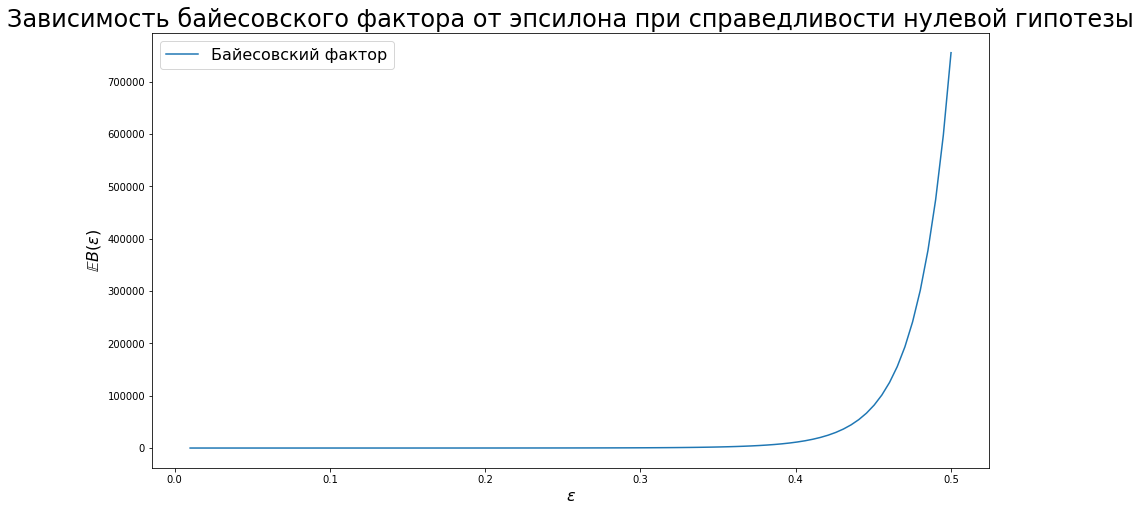

In [93]:
x = sps.norm(0, 1).rvs((1000, 100))

eps = np.linspace(0.01, 0.5, 100)

B = []

for e in tqdm_notebook(eps):
    B.append(np.mean([normal_test_known_var_sh_modification(x[i], 0, 1, eps=e).B  for i in range(1000)]))

plt.figure(figsize=(15, 8))
plt.plot(eps, B, label='Байесовский фактор')
plt.title('Зависимость байесовского фактора от эпсилона при справедливости нулевой гипотезы', fontsize=24)
plt.legend(fontsize=16)
plt.xlabel('$\epsilon$', fontsize=16)
plt.ylabel('$\mathbb{E}B(\epsilon)$', fontsize=16)
plt.show()

---

$H_0: \theta = 0$

$\epsilon = 0.1$

Чем ближе $\theta$ к 0, тем байесовский фактор больше. 

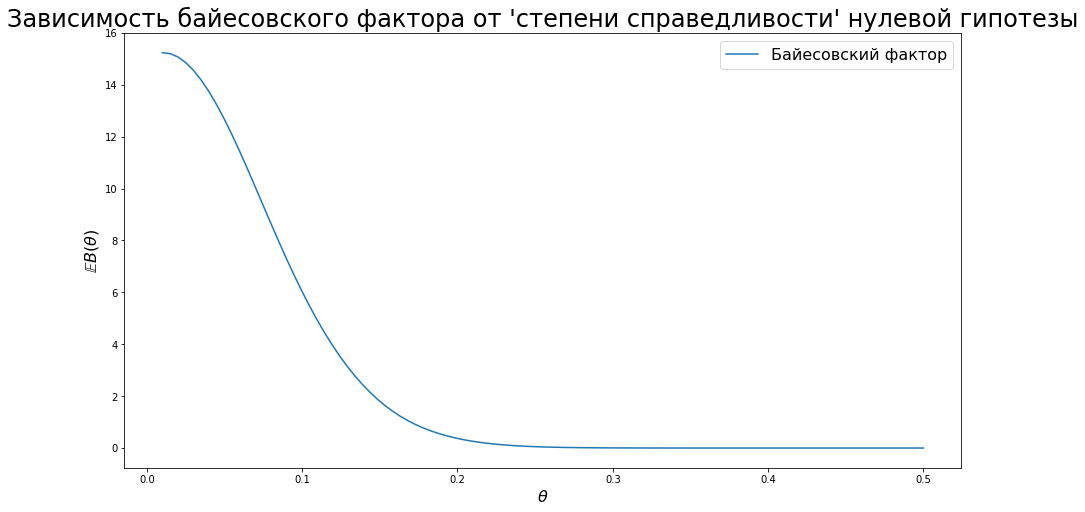

In [102]:
x = sps.norm(0, 1).rvs((1000, 100))

t = np.linspace(0, 1, 100)

B = []

for i in tqdm_notebook(range(len(t))):
    B.append(np.mean([normal_test_known_var_sh_modification(t[i] + x[j], 0, 1, eps=0.1).B  for j in range(1000)]))

plt.figure(figsize=(15, 8))
plt.plot(eps, B, label='Байесовский фактор')
plt.title('Зависимость байесовского фактора от \'степени справедливости\' нулевой гипотезы', fontsize=24)
plt.legend(fontsize=16)
plt.xlabel('$\\theta$', fontsize=16)
plt.ylabel('$\mathbb{E}B(\\theta)$', fontsize=16)
plt.show()

---

$H_0: \theta = 0$

$\epsilon = 0.05$

Если $\theta > 0$, то байесовский фактор при альтернативе $H_1: \theta > 0$ должен быть меньше же, чем при альтернативе $\theta \neq 0$.

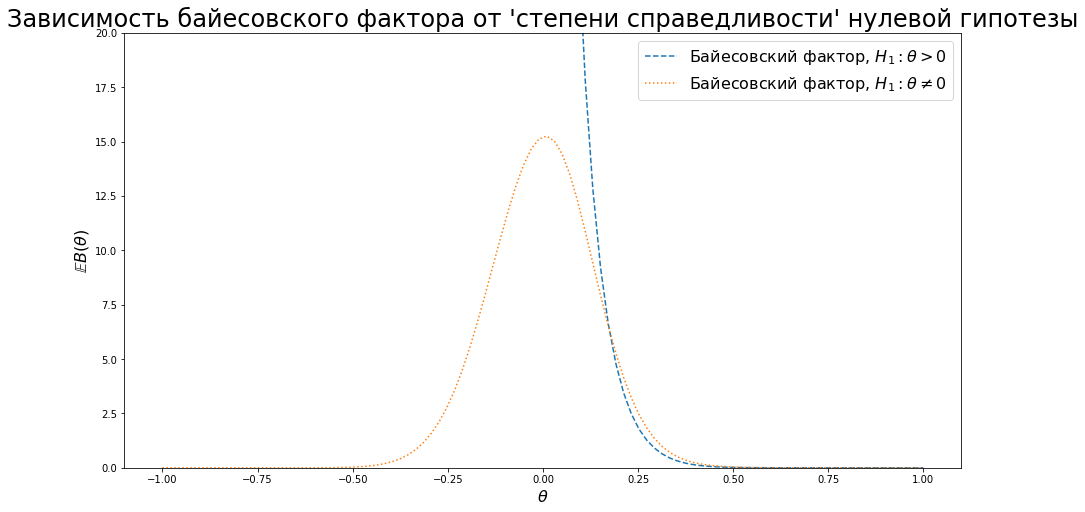

In [4]:
x = sps.norm(0, 1).rvs((1000, 100))

t = np.linspace(-1, 1, 100)

B_greater = []
B_all = []

for i in tqdm_notebook(range(len(t))):
    B_greater.append(np.mean([normal_test_known_var_sh_modification(t[i] + x[j], 0, 1, eps=0.1, alternative='greater').B  
                      for j in range(1000)]))
    B_all.append(np.mean([normal_test_known_var_sh_modification(t[i] + x[j], 0, 1, eps=0.1, alternative='two-sided').B  
                      for j in range(1000)]))

plt.figure(figsize=(15, 8))
plt.plot(t, B_greater, '--', label='Байесовский фактор, $H_1: \\theta > 0$')
plt.plot(t, B_all, ':', label='Байесовский фактор, $H_1: \\theta \\neq 0$')
plt.title('Зависимость байесовского фактора от \'степени справедливости\' нулевой гипотезы', fontsize=24)
plt.legend(fontsize=16)
plt.xlabel('$\\theta$', fontsize=16)
plt.ylabel('$\mathbb{E}B(\\theta)$', fontsize=16)
plt.ylim((0, 20))
plt.show()

### III. Гипотеза: простая vs. сложная, метод Линдли.

Дано: 

1) Выборка $X_1, ..., X_n \sim \mathcal{N}(\theta, \sigma^2)$, $\sigma^2$ известна.

2) Априорное распределение $q_{pr} \sim \mathcal{N}(t_0, \sigma_{pr}^2)$.

---------

Тестируется гипотеза: $H_0: \theta = t_0 ~vs~ H_1: \theta \neq t_0$.

Апостериорное распределение: $\theta | X \sim \mathcal{N}(t_{post}, \sigma_{post}^2)$, где:

* $\Large t_{post} = \frac{\frac{\sum\limits_{i=1}^n X_i}{\sigma^2} + \frac{t_0}{\sigma_{pr}^2}}{\frac{n}{\sigma^2} + \frac{1}{\sigma_{pr}^2}} = ~[$В нашем случае $\sigma = \sigma_{pr}$ $\Large ] ~= \frac{\sum\limits_{i=1}^n X_i + t_0}{n + 1}$

* $\Large \sigma_{post}^2 = \frac{1}{\frac{n}{\sigma^2} + \frac{1}{\sigma_{pr}^2}} = ~[$ В нашем случае $\sigma = \sigma_{pr} $ $\Large ] ~= \frac{\sigma^2}{n + 1}$

Рассмотрим такое множество $\Theta_0 = \{\theta \in \Theta ~|~ p_{post}(\theta) \geq c_{\alpha}\}$, что $P_{post}(\Theta_0) = \alpha$.

Тогда гипотеза $H_0$ отвергается, если $t_0 \notin \Theta_0$.

In [85]:
import numpy as np
import scipy.stats as sps

from collections import namedtuple

def normal_test_known_var_sh_lindley(x, t_pr, sigma, alpha=0.95, alternative='two-sided'):
    """ 
    Parameters
    ----------
    x: numpy array
        Array of samples, should be one-dimensional.  
    t_pr : float
        prior loc parameter
    sigma : positive float
        prior std  parameter
    alpha : float, from [0:1]
        importance level
    alternative : 'less', 'two-sided', или 'greater'
        тип тестируемой гипотезы

    Returns
    -------
    t_post : float
    sigma_post : float
    HDR: tuple, (float, float)
    reject : bool
    """
    
    assert len(x.shape) == 1
    
    n = x.shape[0]
    
    # Параметры апостериорного распределения 
    t_post = (x.sum() + t_pr) / (n + 1)
    sigma_post = sigma / ((n + 1) ** 0.5)
    
    # Апостериорное распределение
    distr_post = sps.norm(loc=t_post, scale=sigma_post)
    
    # Вычисляем границы доверительного интервала на апостериорном распределении
    if alternative == 'two-sided':
        theta_left, theta_right = distr_post.interval(alpha)
    elif alternative == 'less':
        theta_left = distr_post.ppf(distr_post.cdf(t_post) * (1 - alpha))
        theta_right = t_post
    elif alternative == 'greater':
        theta_left = t_post
        theta_right = distr_post.ppf(1 - distr_post.sf(t_post) * (1 - alpha))
    else:
        raise Exception("Unknown alternative")
    
    return namedtuple('test_result', ('t_post', 'sigma_post', 'HDR', 'reject')) \
            (t_post, sigma_post, (theta_left, theta_right), not (theta_left <= t_pr and t_pr <= theta_right))

---

##### Тесты

---

$H_0: \theta = 0$

$\alpha = 0.95$

Проверим, как менятеся вероятность отвержения гипотезы при разных $\theta$ и разных альтернативах.

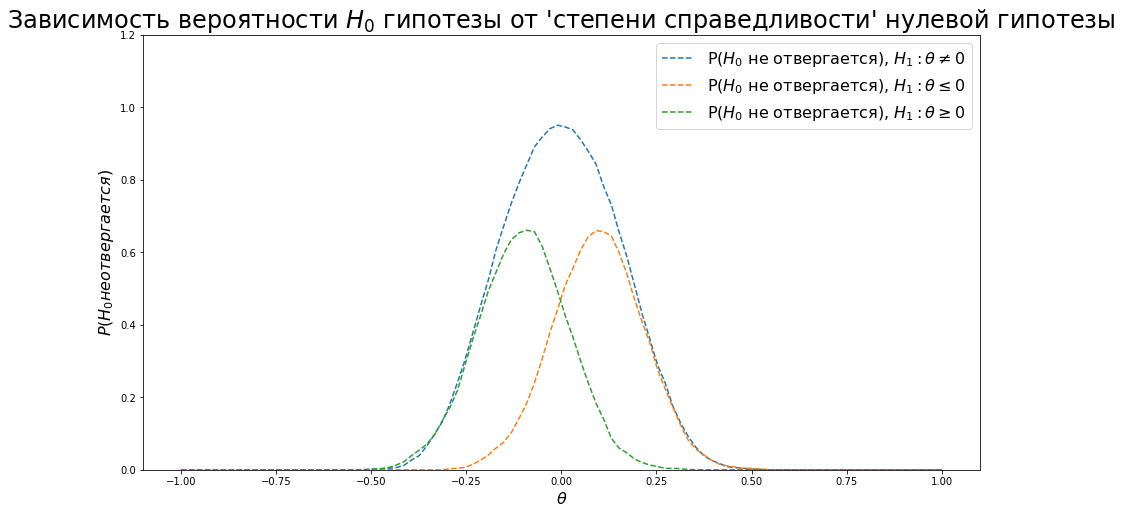

In [42]:
x = sps.norm(0, 1).rvs((1000, 100))

t = np.linspace(-1, 1, 100)

reject_two_sided = []
reject_less = []
reject_greater = []

for i in tqdm_notebook(range(len(t))):
    reject_two_sided.append(1 - np.mean([normal_test_known_var_sh_lindley(t[i] + x[j], 0, 1, alternative='two-sided').reject
                     for j in range(1000)]))
    reject_less.append(1 - np.mean([normal_test_known_var_sh_lindley(t[i] + x[j], 0, 1, alternative='less').reject
                      for j in range(1000)]))
    reject_greater.append(1 - np.mean([normal_test_known_var_sh_lindley(t[i] + x[j], 0, 1, alternative='greater').reject
                      for j in range(1000)]))

plt.figure(figsize=(15, 8))
plt.plot(t, reject_two_sided, '--', label='P($H_0$ не отвергается), $H_1: \\theta \\neq 0$')
plt.plot(t, reject_less, '--', label='P($H_0$ не отвергается), $H_1: \\theta \\leq 0$')
plt.plot(t, reject_greater, '--', label='P($H_0$ не отвергается), $H_1: \\theta \\geq 0$')
plt.title('Зависимость вероятности $H_0$ гипотезы от \'степени справедливости\' нулевой гипотезы', 
          fontsize=24)
plt.legend(fontsize=16)
plt.xlabel('$\\theta$', fontsize=16)
plt.ylabel('$P(H_0 не отвергается)$', fontsize=16)
plt.ylim((0, 1.2))
plt.show()

### IV. Гипотеза: простая vs. сложная, априор с атомом.

Дано: 

1) Выборка $X_1, ..., X_n \sim \mathcal{N}(\theta, \sigma^2)$, $\sigma^2$ известна.

2) Априорное распределение $q_{pr} \sim \pi_0I\{\theta = t_0\} + (1 - \pi_0)\mathcal{N}(t_0, \sigma_{pr}^2)$.

3) $\pi_0$ $-$ априорная вероятность гипотезы $H_0$.

---------

Тестируется гипотеза: $H_0: \theta = t_0 ~vs~ H_1: \theta \neq t_0$.

Апостериорное распределение: $\theta | X \sim p_0I\{\theta = t_0\} + (1 - p_0)\mathcal{N}(t_{post}, \sigma_{post}^2)$, где:

* $\Large t_{post} = \frac{\frac{\sum\limits_{i=1}^n X_i}{\sigma^2} + \frac{t_0}{\sigma_{pr}^2}}{\frac{n}{\sigma^2} + \frac{1}{\sigma_{pr}^2}} = ~[$В нашем случае $\sigma = \sigma_{pr}$ $\Large ] ~= \frac{\sum\limits_{i=1}^n X_i + t_0}{n + 1}$

* $\Large \sigma_{post}^2 = \frac{1}{\frac{n}{\sigma^2} + \frac{1}{\sigma_{pr}^2}} = ~[$ В нашем случае $\sigma = \sigma_{pr} $ $\Large ] ~= \frac{\sigma^2}{n + 1}$

Байесовский фактор вычисляется как $\Large B = \frac{p_0\pi_1}{p_1\pi_0}$, где:

* $\pi_0, \pi_1 ~-$ априорные вероятности соответствующих гипотез.

* $p_0, p_1 ~-$ апостериорные вероятности соответствующих гипотез.

Тогда байесовский фактор выражается как $\Large B = \frac{f_{t_0}(\overline{X})}{f(\overline{X})}$, где:

* $f_{t_0}(\overline{X})$ - плотность $\mathcal{N}(t_0, \frac{\sigma^2}{n} + \sigma^2)$ в точке $\overline{X}$.
* $f(\overline{X})$ - плотность $\mathcal{N}(t_0, \frac{\sigma^2}{n})$ в точке $\overline X$.

И, наконец, $\Large p_0 = \frac{1}{1 + \frac{1 - \pi_0}{\pi_0B}}$.

In [129]:
import numpy as np
import scipy.stats as sps

from collections import namedtuple

def normal_test_known_var_sh_atom(x, t_pr, sigma, pi_0):
    """ 
    Parameters
    ----------
    x: numpy array
        Array of samples, should be one-dimensional.  
    t_pr : float
        prior loc parameter
    sigma : positive float
        prior std  parameter
    pi_0 : float, from [0:1]
        априорная вероятность гипотезы H_0

    Returns
    -------
    t_post : float
    sigma_post : float
    p_0 : float
        апостериорная вероятность гипотезы H_0
    B : float
        байесовский фактор
    """
    
    assert len(x.shape) == 1
    
    n = x.shape[0]
    S = x.mean()
    
    # Параметры апостериорного распределения 
    t_post = (x.sum() + t_pr) / (n + 1)
    sigma_post = sigma / ((n + 1) ** 0.5)
    
    # Апостериорное распределение
    distr_post = sps.norm(loc=t_post, scale=sigma_post)
    
    # Байесовский фактор
    B = sps.norm(loc=t_pr, scale=sigma / (n ** 0.5)).pdf(S) / \
        sps.norm(loc=t_pr, scale=(((n + 1) / n) ** 0.5) * sigma).pdf(S)
        
    # Апостериорная вероятность нулевой гипотезы 
    p_0 = 1 / (1 + (1 - pi_0) / (pi_0 * B))
    
    return namedtuple('test_result', ('t_post', 'sigma_post', 'p_0', 'B')) \
            (t_post, sigma_post, p_0, B)

---

##### Тесты

---

$H_0: \theta = 0 ~vs~ H_1: \theta \neq 0$

$X_1, ..., X_{100} \sim \mathcal{N}(0, 1)$

Проверим, как менятеся апостериорная вероятность при разных априорных вероятностях.

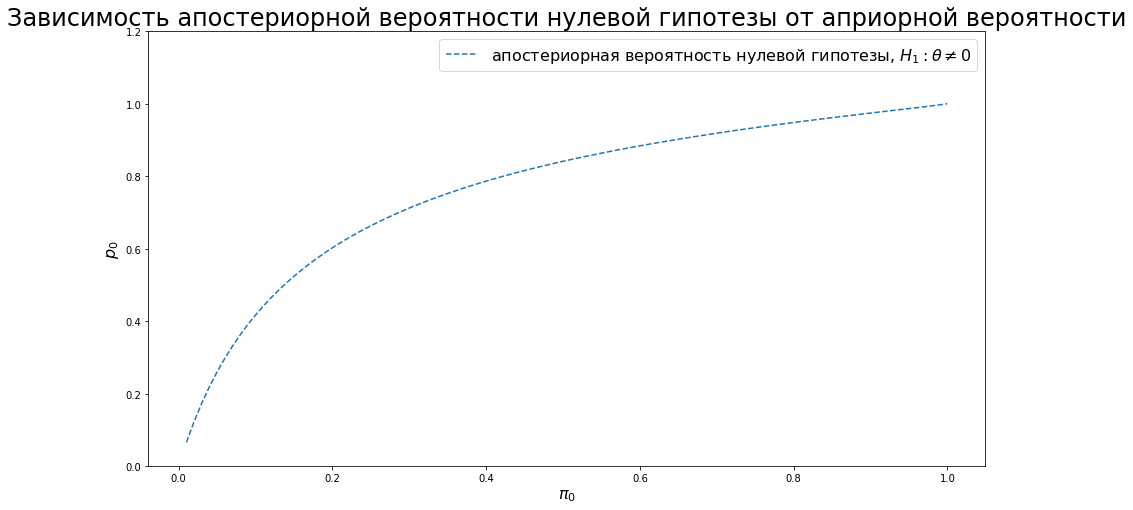

In [130]:
x = sps.norm(0, 1).rvs((1000, 100))

pi = np.linspace(0.01, 1, 100)

p = []

for i in tqdm_notebook(range(len(pi))):
    p.append(np.mean([normal_test_known_var_sh_atom(x[j], 0, 1, pi_0=pi[i]).p_0 for j in range(1000)]))

plt.figure(figsize=(15, 8))
plt.plot(pi, p, '--', label='апостериорная вероятность нулевой гипотезы, $H_1: \\theta \\neq 0$')
plt.title('Зависимость апостериорной вероятности нулевой гипотезы от априорной вероятности', fontsize=24)
plt.legend(fontsize=16)
plt.xlabel('$\\pi_0$', fontsize=16)
plt.ylabel('$p_0$', fontsize=16)
plt.ylim((0, 1.2))
plt.show()

### V. Гипотеза: сложная vs. сложная.

Дано: 

1) Выборка $X_1, ..., X_n \sim \mathcal{N}(\theta, \sigma^2)$, $\sigma^2$ известна.

2) Априорное распределение $q_{pr} \sim \mathcal{N}(t_0, \sigma_{pr}^2)$.

---------

Тестируется гипотеза: $H_0: \theta \leq t_0 ~vs~ H_1: \theta > t_0$.

$\pi_0 = P_{pr}(\theta < t_0)$

$p_0 = P_{post}(\theta < t_0)$

$\large B = \frac{p_0\backslash p_1}{\pi_0\backslash \pi_1}$

In [99]:
from collections import namedtuple

def normal_test_known_var_hh(x, t_pr, sigma, alternative='greater'):
    """ 
    Parameters
    ----------
    x: numpy array
        Array of samples, should be one-dimensional.  
    t_pr : float
        prior loc parameter
    sigma : positive float
        prior std parameter
    Returns
    -------
    t_post : float
    sigma_post : float
    B : float
    p_0 : float
    """
    
    assert len(x.shape) == 1
    
    n = x.shape[0]
    
    # Априорное распределение
    distr_pr = sps.norm(loc=t_pr, scale=sigma)
    
    # Параметры апостериорного распределения 
    t_post = (x.sum() + t_pr) / (n + 1)
    sigma_post = sigma / ((n + 1) ** 0.5)
    
    # Апостериорное распределение
    distr_post = sps.norm(loc=t_post, scale=sigma_post)
    
    # Вычисляем априорные вероятности гипотез
    # Вообще говоря, в данном случае они равны 0.5
    pi_0 = distr_pr.cdf(t_pr) if alternative == 'greater' else distr_pr.sf(t_pr)
    pi_1 = 1 - pi_0  
    
    # Вычисляем апостериорные вероятности
    p_0 = distr_post.cdf(t_pr) if alternative == 'greater' else distr_post.sf(t_pr)
    p_1 = 1 - p_0
    
    # Вычисляем байесовский фактор
    B = (p_0 / p_1) / (pi_0 / pi_1) 
    
    # Вычисляем доверительный интервал
    theta_left, theta_right = distr_post.interval(alpha)
    
    return namedtuple('test_result', ('t_post', 'sigma_post', 'B', 'p_0', 'HDR')) \
        (t_post, sigma_post, B, p_0, (theta_left, theta_right))

---

##### Тесты

---

$H_0: \theta \leq t_0 ~vs~ H_1: \theta > t_0$

$X_1, ..., X_{100} \sim \mathcal{N}(0, 1)$

Чем больше $t_0$, тем больше байесовский фактор.

/Users/v-buchnev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars


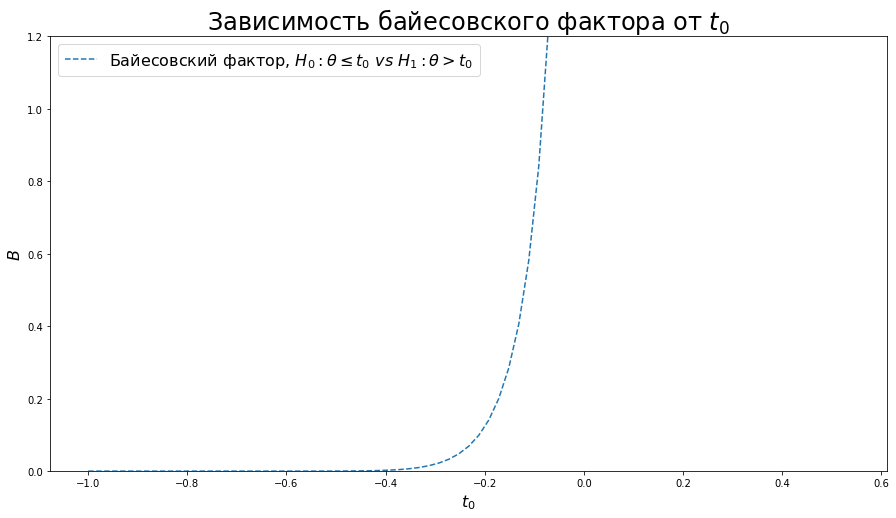

In [83]:
x = sps.norm(0, 1).rvs((1000, 100))

t = np.linspace(-1, 1, 100)

B = []

for i in tqdm_notebook(range(len(pi))):
    B.append(np.mean([normal_test_known_var_hh(x[j], t[i], 1).B for j in range(1000)]))

plt.figure(figsize=(15, 8))
plt.plot(t, B, '--', label='Байесовский фактор, $H_0: \\theta \\leq t_0 ~vs~ H_1: \\theta > t_0$')
plt.title('Зависимость байесовского фактора от $t_0$', fontsize=24)
plt.legend(fontsize=16)
plt.xlabel('$t_0$', fontsize=16)
plt.ylabel('$B$', fontsize=16)
plt.ylim((0, 1.2))
plt.show()

# Две нормальные независимые выборки, дисперсия известна, гипотеза $H_0: \theta_x = \theta_y ~vs~ H_1: \theta_x \neq \theta_y$

Дано: 

1) Выборка $X_1, ..., X_n \sim \mathcal{N}(\theta_x, \sigma_x^2)$, $\sigma_x^2$ известна.

2) Выборка $Y_1, ..., Y_n \sim \mathcal{N}(\theta_y, \sigma_y^2)$, $\sigma_y^2$ известна.

3) Априорное распределение $q_{x pr} \sim \mathcal{N}(t_{0}, \sigma_{x pr}^2)$.

4) Априорное распределение $q_{y pr} \sim \mathcal{N}(t_{0}, \sigma_{y pr}^2)$.

---------

Тестируется гипотеза: $H_0: \theta_x = \theta_y ~vs~ H_1: \theta_x \neq \theta_y$.

Считаем апостериорное распределение по тем же самым формулам, что и для гипотез выше:

$\theta_x ~|~X \sim \mathcal{N}(a_x, \psi_x^2)$

$\theta_y ~|~Y \sim \mathcal{N}(a_y, \psi_y^2)$

Пусть $\delta = X - Y \sim \mathcal{N}(\theta_x - \theta_y, \sigma_x^2 + \sigma_y^2)$.

Тогда  $\delta ~|~ X, Y \sim \mathcal{N}(a_x - a_y, \psi_x^2 + \psi_y^2)$

И проверяемая гипотеза сводится к:

$H_0: \theta_{\delta} = 0 ~vs~ H_1: \theta_{\delta} \neq 0$, что можно проверить через тесты, написанныые выше.

In [122]:
from collections import namedtuple

def normal_test_known_var_2_samples(x, y, t_pr, sigma_x, sigma_y, hypothesis_type='modification', 
                             alternative='two-sided', eps=0.05, alpha=0.95, pi_0=0.5):
    """ 
    Parameters
    ----------
    x: numpy array
        Array of samples, should be one-dimensional.  
    t_pr : float
        prior loc parameter
    sigma_x : positive float
        prior std parameter of x
    sigma_y : positive float
        prior std parameter of y
    alternative : 'less', 'two-sided', или 'greater'
        тип тестируемой гипотезы
    eps: positive float
        width of null hypothesis (for hypothesis_type == \'modification\')
    alpha: float, from [0, 1]
        importance level (for hypothesis_type == \'lindley\')
    pi_0: float, from [0, 1]
        prior probability of null hypothesis (for hypothesis_type == \'atom\')
    Returns
    -------
    If modification:
        t_post : float
        sigma_post : float
        B : float
    If Lindley:
        t_post : float
        sigma_post : float
        HDR: tuple, (float, float)
        reject : bool
    If atom:
        t_post : float
        sigma_post : float
        p_0 : float
            апостериорная вероятность гипотезы H_0
        B : float
            байесовский фактор
    """
    
    assert len(x.shape) == 1
    
    n = x.shape[0]
    
    # Априорное распределение
    distr_x_pr = sps.norm(loc=t_pr, scale=sigma_x)
    distr_y_pr = sps.norm(loc=t_pr, scale=sigma_y)
    
    # Параметры апостериорного распределения 
    t_x_post = (x.sum() + t_pr) / (n + 1)
    sigma_x_post = sigma_x / ((n + 1) ** 0.5)
    t_y_post = (y.sum() + t_pr) / (n + 1)
    sigma_y_post = sigma_y / ((n + 1) ** 0.5)
    
    # Апостериорное распределение
    distr_x_post = sps.norm(loc=t_x_post, scale=sigma_x_post)
    distr_y_post = sps.norm(loc=t_y_post, scale=sigma_y_post)
    
    delta = x - y
    sigma_delta = (sigma_x ** 2 + sigma_y ** 2) ** 0.5
    
    if hypothesis_type == 'modification':
        return normal_test_known_var_sh_modification(delta, 0, sigma_delta, alternative=alternative)
    elif hypothesis_type == 'lindley':
        return normal_test_known_var_sh_lindley(delta, 0, sigma_delta, alternative=alternative)
    elif hypothesis_type == 'atom':
        return normal_test_known_var_sh_atom(delta, 0, sigma_delta, pi_0)
    else:
        raise Exception("Unknown hypothesis_type")

---

##### Тесты

---

$H_0: \theta_x = \theta_y ~vs~ H_1: \theta_x \neq \theta_y$

$X_1, ..., X_{100} \sim \mathcal{N}(0, 1)$

$Y_1, ..., Y_{100} \sim \mathcal{N}(t, 1)$, $t \in [-1, 1]$

Чем больше $t$ по модулю, тем меньше байесовский фактор.

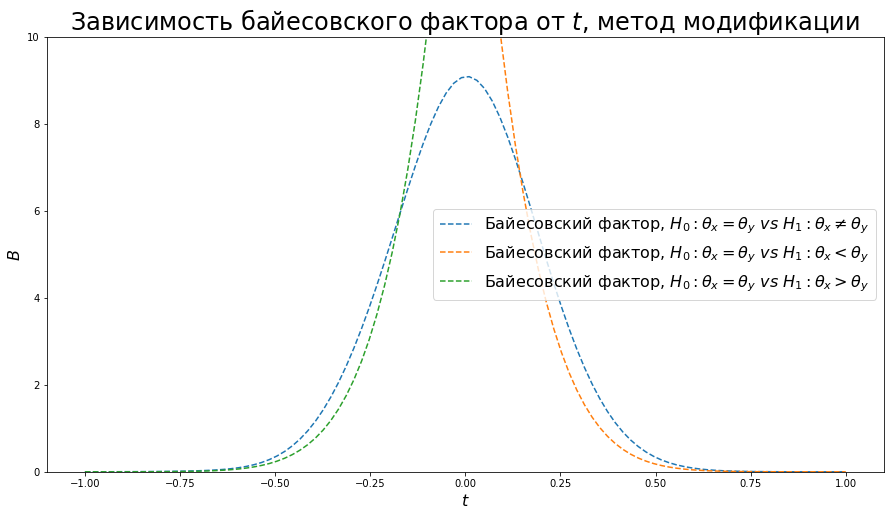

In [114]:
x = sps.norm(0, 1).rvs((1000, 100))
y = sps.norm(0, 1).rvs((1000, 100))

t = np.linspace(-1, 1, 100)

B_two_sided = []
B_less = []
B_greater = []

for i in tqdm_notebook(range(len(pi))):
    B_two_sided.append(np.mean([normal_test_known_var_2_samples(x[j], y[j] + t[i], 0, 1, 1, 
                                                                alternative='two_sided').B for j in range(1000)]))
    B_less.append(np.mean([normal_test_known_var_2_samples(x[j], y[j] + t[i], 0, 1, 1, 
                                                                alternative='less').B for j in range(1000)]))
    B_greater.append(np.mean([normal_test_known_var_2_samples(x[j], y[j] + t[i], 0, 1, 1, 
                                                                alternative='greater').B for j in range(1000)]))
    

plt.figure(figsize=(15, 8))
plt.plot(t, B_two_sided, '--', 
         label='Байесовский фактор, $H_0: \\theta_x = \\theta_y ~vs~ H_1: \\theta_x \\neq \\theta_y$')
plt.plot(t, B_less, '--', 
         label='Байесовский фактор, $H_0: \\theta_x = \\theta_y ~vs~ H_1: \\theta_x < \\theta_y$')
plt.plot(t, B_greater, '--', 
         label='Байесовский фактор, $H_0: \\theta_x = \\theta_y ~vs~ H_1: \\theta_x > \\theta_y$')
plt.title('Зависимость байесовского фактора от $t$, метод модификации', fontsize=24)
plt.legend(fontsize=16)
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$B$', fontsize=16)
plt.ylim((0, 10))
plt.show()

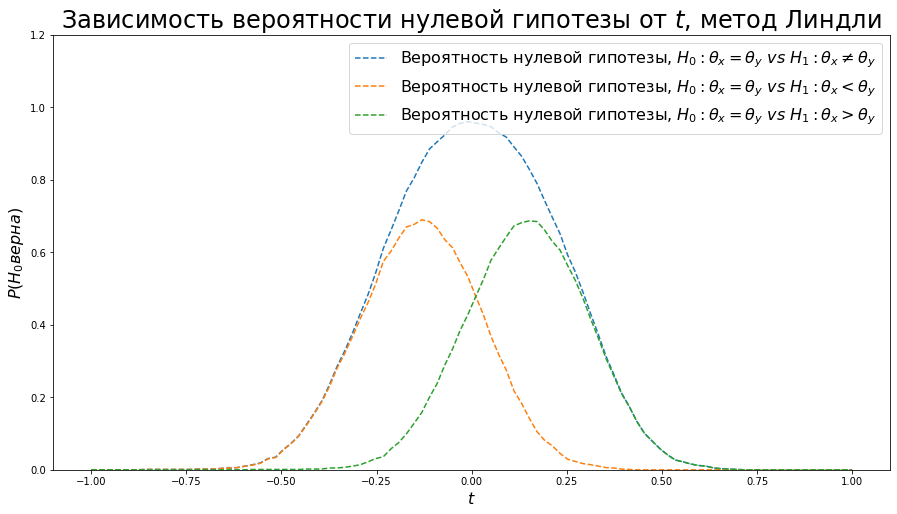

In [120]:
x = sps.norm(0, 1).rvs((1000, 100))
y = sps.norm(0, 1).rvs((1000, 100))

t = np.linspace(-1, 1, 100)

# p_two_sided = []
# p_less = []
# p_greater = []

# for i in tqdm_notebook(range(len(pi))):
#     p_two_sided.append(1 - np.mean([normal_test_known_var_2_samples(x[j], y[j] + t[i], 0, 1, 1, 
#                                                                      hypothesis_type='lindley', 
#                                                                      alternative='two-sided').reject for j in range(1000)]))
#     p_less.append(1 - np.mean([normal_test_known_var_2_samples(x[j], y[j] + t[i], 0, 1, 1, 
#                                                                 hypothesis_type='lindley',
#                                                                 alternative='less').reject for j in range(1000)]))
#     p_greater.append(1 - np.mean([normal_test_known_var_2_samples(x[j], y[j] + t[i], 0, 1, 1, 
#                                                                    hypothesis_type='lindley', 
#                                                                    alternative='greater').reject for j in range(1000)]))
    

plt.figure(figsize=(15, 8))
plt.plot(t, p_two_sided, '--', 
         label='Вероятность нулевой гипотезы, $H_0: \\theta_x = \\theta_y ~vs~ H_1: \\theta_x \\neq \\theta_y$')
plt.plot(t, p_less, '--', 
         label='Вероятность нулевой гипотезы, $H_0: \\theta_x = \\theta_y ~vs~ H_1: \\theta_x < \\theta_y$')
plt.plot(t, p_greater, '--', 
         label='Вероятность нулевой гипотезы, $H_0: \\theta_x = \\theta_y ~vs~ H_1: \\theta_x > \\theta_y$')
plt.title('Зависимость вероятности нулевой гипотезы от $t$, метод Линдли', fontsize=24)
plt.legend(fontsize=16)
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$P(H_0 верна)$', fontsize=16)
plt.ylim((0, 1.2))
plt.show()

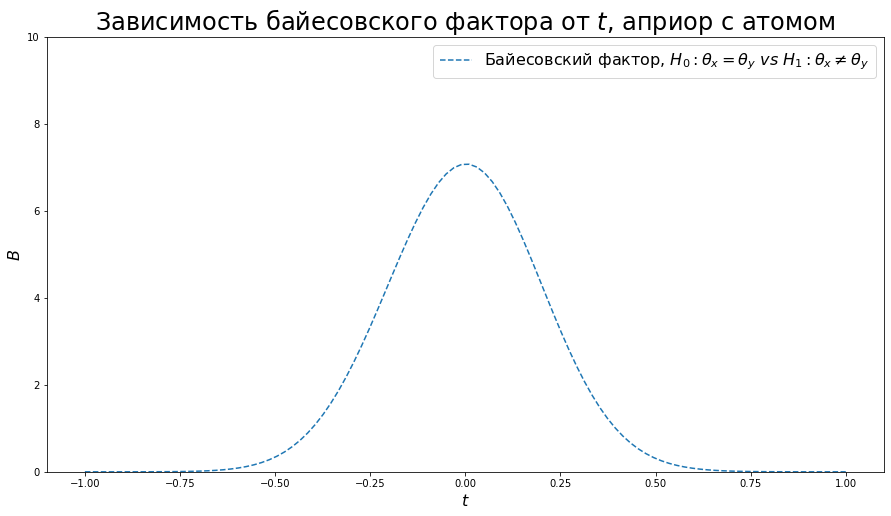

In [132]:
x = sps.norm(0, 1).rvs((1000, 100))
y = sps.norm(0, 1).rvs((1000, 100))

t = np.linspace(-1, 1, 100)

B_two_sided = []

for i in tqdm_notebook(range(len(pi))):
    B_two_sided.append(np.mean([normal_test_known_var_2_samples(x[j], y[j] + t[i], 0, 1, 1, hypothesis_type='atom',
                                                                alternative='two_sided').B for j in range(1000)]))

plt.figure(figsize=(15, 8))
plt.plot(t, np.array(B_two_sided), '--', 
         label='Байесовский фактор, $H_0: \\theta_x = \\theta_y ~vs~ H_1: \\theta_x \\neq \\theta_y$')
plt.title('Зависимость байесовского фактора от $t$, априор с атомом', fontsize=24)
plt.legend(fontsize=16)
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$B$', fontsize=16)
plt.ylim((0, 10))
plt.show()